In [39]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

In [2]:
emotions = load_dataset("emotion")
emotions

/Users/david/Repos/nlp-processing-with-transformers/.venv/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train_dataset = emotions["train"]
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
len(train_dataset)

16000

In [5]:
train_dataset[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
train_dataset.column_names

['text', 'label']

In [7]:
train_dataset[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [8]:
train_dataset["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [9]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [11]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


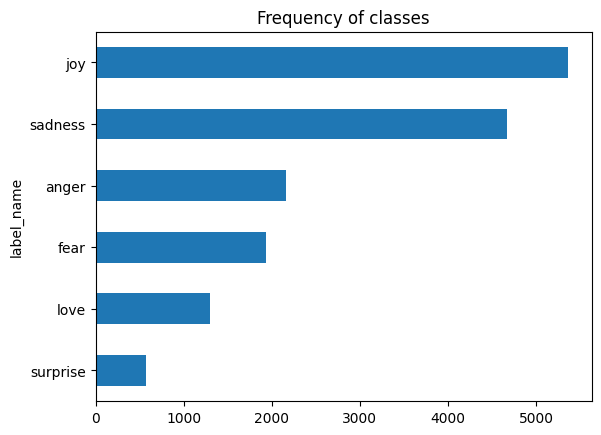

In [12]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

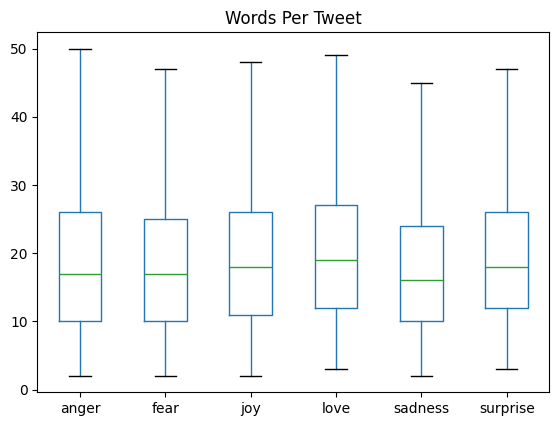

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions.reset_format()

In [15]:
text = "Tokenizing text is a core task of NLP."

In [16]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/Users/david/Repos/nlp-processing-with-transformers/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [17]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [18]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [19]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


The `AutoTokenizer` class also has several attributes that provide information about the tokenizer. For example, we inspect the vocabulary size.


In [20]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:


In [21]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:


In [22]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenizing the whole dataset


In [23]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [24]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:


In [25]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

By default, the `map`method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` column to the dataset:


In [26]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Transformers as Feature Extractors


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

The model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.


In [28]:
model = AutoModel.from_pretrained(model_checkpoint).to(device)

/Users/david/Repos/nlp-processing-with-transformers/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Extracting the last hidden states


In [33]:
example_text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
inputs_items = inputs.items()
print(f"Input items: {inputs_items}")
print(f"Input tensor: {inputs['input_ids']}")
inputs = {k: v.to(device) for k, v in inputs_items}
print(f"Inputs: {inputs}")
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Input items: dict_items([('input_ids', tensor([[  101, 19204,  6026,  3793,  2003,  1037,  4563,  4708,  1997, 17953,
          2361,  1012,   102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))])
Input tensor: tensor([[  101, 19204,  6026,  3793,  2003,  1037,  4563,  4708,  1997, 17953,
          2361,  1012,   102]])
Inputs: {'input_ids': tensor([[  101, 19204,  6026,  3793,  2003,  1037,  4563,  4708,  1997, 17953,
          2361,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
BaseModelOutput(last_hidden_state=tensor([[[-0.5274, -0.2094, -0.3702,  ..., -0.2226, -0.2209,  0.6306],
         [-0.8933,  0.1909, -0.5291,  ..., -0.3937, -0.1585,  0.3817],
         [-0.5556,  0.1427, -0.5014,  ..., -0.3935, -0.3470,  0.6484],
         ...,
         [-0.4909, -0.3005, -0.0368,  ..., -0.0892, -0.6761,  0.3377],
         [ 0.5523, -0.0374, -0.6801,  ...,  0.2615, -0.7397, -0.2420],
         [ 0.4775,  0.1837, -0.4203,  ...,  0

In our example, the model output is an instance of `BaseModelOutput`, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let's examine its shape:


In [30]:
outputs.last_hidden_state.size()

torch.Size([1, 13, 768])

In [31]:
outputs.last_hidden_state

tensor([[[-0.5274, -0.2094, -0.3702,  ..., -0.2226, -0.2209,  0.6306],
         [-0.8933,  0.1909, -0.5291,  ..., -0.3937, -0.1585,  0.3817],
         [-0.5556,  0.1427, -0.5014,  ..., -0.3935, -0.3470,  0.6484],
         ...,
         [-0.4909, -0.3005, -0.0368,  ..., -0.0892, -0.6761,  0.3377],
         [ 0.5523, -0.0374, -0.6801,  ...,  0.2615, -0.7397, -0.2420],
         [ 0.4775,  0.1837, -0.4203,  ...,  0.2080, -0.9114, -0.0827]]])

For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into `outputs.last_hidden_state` as follows:


In [32]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [34]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU/CPU
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        # Forward pass through the model
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

Since our model expects tensors as inputs, the next thing to do is convert the `input_ids` and `attention_mask` columns to the "torch" format as follows:


In [35]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [36]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [37]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Creating a feature matrix


In [41]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions["train"]["label"])
y_valid = np.array(emotions["validation"]["label"])
X_train.shape, y_train.shape

((16000, 768), (16000,))